# Set transpiler optimization level

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=1.3.2
qiskit-ibm-runtime~=0.34.0
qiskit-aer~=0.15.1
qiskit-serverless~=0.18.1
qiskit-ibm-catalog~=0.2
qiskit-addon-sqd~=0.8.1
qiskit-addon-utils~=0.1.0
qiskit-addon-mpf~=0.2.0
qiskit-addon-aqc-tensor~=0.1.2
qiskit-addon-obp~=0.1.0
scipy~=1.15.1
pyscf~=2.8.0; sys.platform != 'win32'
```
</details>

Real quantum devices are subject to noise and gate errors, so optimizing the circuits to reduce their depth and gate count can significantly improve the results obtained from executing those circuits.
The [`generate_preset_pass_manager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function has one required positional argument, `optimization_level`, that controls how much effort the transpiler spends on optimizing circuits. This argument can be an integer taking one of the values 0, 1, 2, or 3.
Higher optimization levels generate more optimized circuits at the expense of longer compile times.
The following table explains the optimizations performed with each setting.

<Table>
  <thead>
    <Tr>
      <Th>Optimization Level</Th>
      <Th>Description</Th>
    </Tr>
  </thead>
  <tbody>
    <Tr>
      <Td>0</Td>
      <Td>
        No optimization: typically used for hardware characterization
        - Basic translation
        - Layout/Routing: `TrivialLayout`, where it selects the same physical qubit numbers as virtual and inserts SWAPs to make it work (using `StochasticSwap`)
      </Td>
    </Tr>
    <Tr>
      <Td>1</Td>
      <Td>
        Light optimization:
        -   Layout/Routing: Layout is first attempted with `TrivialLayout`. If additional SWAPs are required, a layout with a minimum number of SWAPs is found by using `SabreSWAP`, then it uses `VF2LayoutPostLayout` to try to select the best qubits in the graph.
        -   `InverseCancellation`
        -   1Q gate optimization
      </Td>
    </Tr>
    <Tr>
      <Td>2</Td>
      <Td>
        Medium optimization:
          - Layout/Routing: Optimization level 1 (without trivial) + heuristic optimized with greater
        search depth and trials of optimization function.  Because `TrivialLayout` is not used, there is no attempt to use the same physical and virtual qubit numbers.
        -   `CommutativeCancellation`
      </Td>
    </Tr>
    <Tr>
      <Td>3</Td>
      <Td>
        High Optimization:
        - Optimization level 2 + heuristic optimized on layout/routing further with greater effort/trials
        - Resynthesis of two-qubit blocks using [Cartan's KAK Decomposition](https://arxiv.org/abs/quant-ph/0507171).
        - Unitarity-breaking passes:
          * `OptimizeSwapBeforeMeasure`: Moves the measurements around to avoid SWAPs
          * `RemoveDiagonalGatesBeforeMeasure`: Removes gates before measurements that would not effect the measurements
      </Td>
    </Tr>
  </tbody>
</Table>

## Optimization level in action

Since two-qubit gates are typically the most significant source of errors, we can approximately quantify the transpilation's "hardware efficiency" by counting the number of two-qubit gates in the resulting circuit.
Here, we'll try the different optimization levels on an input circuit consisting of a random unitary followed by a SWAP gate.

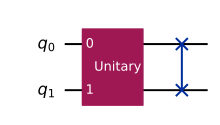

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator, random_unitary

UU = random_unitary(4, seed=12345)
rand_U = UnitaryGate(UU)

qc = QuantumCircuit(2)
qc.append(rand_U, range(2))
qc.swap(0, 1)
qc.draw("mpl", style="iqp")

We'll use the `FakeSherbrooke` mock backend in our examples. First, let's transpile using optimization level 0.

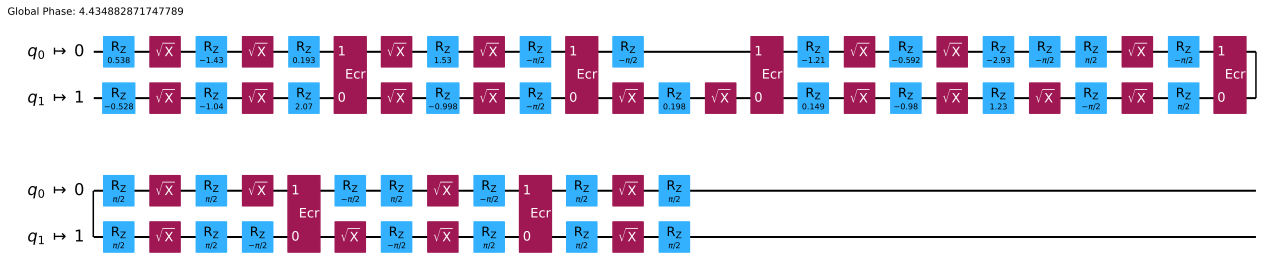

In [2]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(
    optimization_level=0, backend=backend, seed_transpiler=12345
)
qc_t1_exact = pass_manager.run(qc)
qc_t1_exact.draw("mpl", idle_wires=False)

The transpiled circuit has six of the two-qubit ECR gates.

Repeat for optimization level 1:

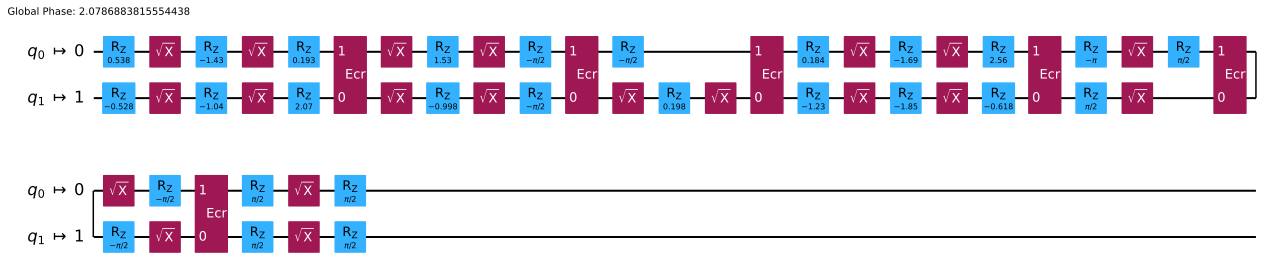

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, seed_transpiler=12345
)
qc_t1_exact = pass_manager.run(qc)
qc_t1_exact.draw("mpl", idle_wires=False)

The transpiled circuit still has six ECR gates, but the number of single-qubit gates has reduced.

Repeat for optimization level 2:

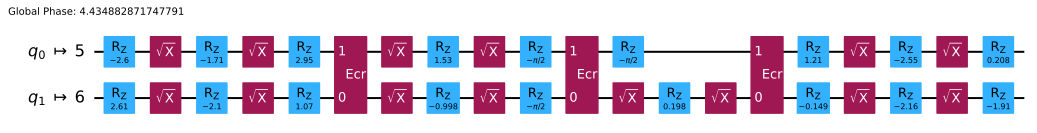

In [4]:
pass_manager = generate_preset_pass_manager(
    optimization_level=2, backend=backend, seed_transpiler=12345
)
qc_t2_exact = pass_manager.run(qc)
qc_t2_exact.draw("mpl", idle_wires=False)

This yields the same results as optimization level 1. Note that increasing the level of optimization does not always make a difference.

Repeat again, with optimization level 3:

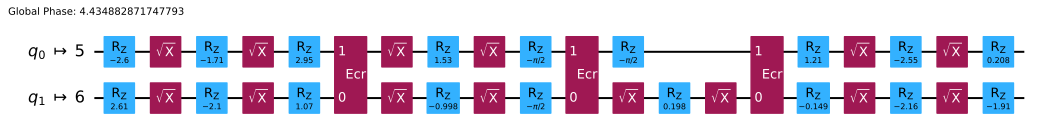

In [5]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=12345
)
qc_t3_exact = pass_manager.run(qc)
qc_t3_exact.draw("mpl", idle_wires=False)

Now, there are only three ECR gates. We obtain this result because at optimization level 3, Qiskit tries to re-synthesize two-qubit blocks of gates, and any two-qubit gate can be implemented using at most three ECR gates. We can get even fewer ECR gates if we set `approximation_degree` to a value less than 1, allowing the transpiler to make approximations that may introduce some error in the gate decomposition (see [Commonly used parameters for transpilation](common-parameters#approximation-degree)):

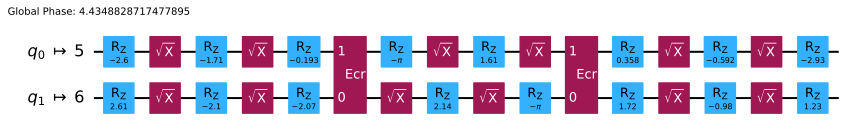

In [6]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    approximation_degree=0.99,
    backend=backend,
    seed_transpiler=12345,
)
qc_t3_approx = pass_manager.run(qc)
qc_t3_approx.draw("mpl", idle_wires=False)

This circuit has only two ECR gates, but it's an approximate circuit. To understand how its effect differs from the exact circuit, we can calculate the fidelity between the unitary operator this circuit implements, and the exact unitary. Before performing the computation, we first reduce the transpiled circuit, which contains 127 qubits, down to a circuit that only contains the active qubits, of which there are two.

In [7]:
import numpy as np


def trace_to_fidelity_2q(trace: float) -> float:
    return (4.0 + trace * trace.conjugate()) / 20.0


# Reduce circuits down to 2 qubits so they are easy to simulate
qc_t3_exact_small = QuantumCircuit.from_instructions(qc_t3_exact)
qc_t3_approx_small = QuantumCircuit.from_instructions(qc_t3_approx)

# Compute the fidelity
exact_fid = trace_to_fidelity_2q(
    np.trace(np.dot(Operator(qc_t3_exact_small).adjoint().data, UU))
)
approx_fid = trace_to_fidelity_2q(
    np.trace(np.dot(Operator(qc_t3_approx_small).adjoint().data, UU))
)
print(
    f"Synthesis fidelity\nExact: {exact_fid:.3f}\nApproximate: {approx_fid:.3f}"
)

Synthesis fidelity
Exact: 1.000+0.000j
Approximate: 0.992+0.000j


Adjusting the optimization level can change other aspects of the circuit too, not just the number of ECR gates. For examples of how setting optimization level changes the layout, see [Representing quantum computers](./represent-quantum-computers).

## Next steps

<Admonition type="tip" title="Recommendations">
    - To learn more about the `generate_preset_passmanager` function, start with the [Transpilation default settings and configuration options](defaults-and-configuration-options) topic.
    - Continue learning about transpilation with the [Transpiler stages](transpiler-stages) topic.
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - Try the [Build repetition codes](https://learning.quantum.ibm.com/tutorial/build-repetition-codes) tutorial.
    - See the [Transpile API documentation.](/api/qiskit/transpiler)
</Admonition>